In [ ]:
# Here we aim to compute the numerical Epsilon-Delta curve with given cactus distribution
# Last Update: 12/09/2021 by Fei

Text(0.5, 1.0, 'PDFs, sen=1.0, var=1.00')

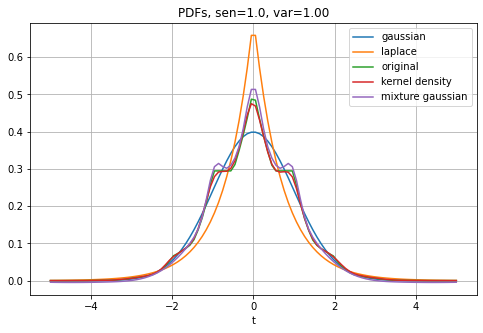

In [2]:
# Generate a kernel density estimator from samples

import numpy as np
import mpmath as mp
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# gaussian pdf
def gaussian_pdf(x,variance):
  return 1/mp.sqrt(2*mp.pi)/mp.sqrt(variance)*mp.exp(-x**2/2/variance)

# laplace pdf
def laplace_pdf(x, variance):
  b = mp.sqrt(variance/2)
  return 1/2/b*mp.exp(-mp.fabs(x)/b)

# the mixture gaussian pdf
def mixture_pdf(x,sen,variance, mixture_number):
  filename = ('privacy_data/mix_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
  [mu_np,sigma_np,weights_np] = np.genfromtxt(filename, dtype=np.float32,delimiter=',')
  s = sum(weights_np)
  return sum([1/mp.sqrt(2*mp.pi)/sigma_np[i]*mp.exp(-(x-mu_np[i])**2/2/(sigma_np[i])**2)*weights_np[i]
              for i in range(mixture_number)])/s
  
  # the kernel density esimation of cactus
def kernel_pdf(x,sen,variance):
  filename = ('privacy_data/cactus_samples_d%1.1f_v%1.2f.npy' %(sen, variance))
  samples=np.load(filename)
  return gaussian_kde(samples).pdf(x)

# the original cactus pdf
def cactus_pdf(X,sen,variance):
  r=0.9
  filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
  x = np.genfromtxt(filename, dtype=np.float32)
  x = x.reshape(-1)
  xmax=max(x)
  n = len(x)/2//xmax

  filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
  p = np.genfromtxt(filename, dtype=np.float32)
  p = p.reshape(-1)    
    
  if np.abs(X)>=xmax:
    y=n*p[-1]*r**(n*(np.abs(X)-xmax))
  else:
    i = np.searchsorted(x,X)
    y = n*p[i]
#     y = n*p[i]+n**2*(p[i+1]-p[i])*(X-x[i])
  return y

sen = 1
variance = 1
mixture_number = 21

x=np.linspace(-5,5,100)
plt.figure(figsize=(8,5))
plt.plot(x,[gaussian_pdf(X,variance) for X in x],label='gaussian')
plt.plot(x,[laplace_pdf(X,variance) for X in x],label='laplace')
plt.plot(x,[cactus_pdf(X,sen,variance) for X in x],label='original')
plt.plot(x,[kernel_pdf(X,sen,variance) for X in x],label='kernel density')
plt.plot(x,[mixture_pdf(X,sen,variance,mixture_number) for X in x],label='mixture gaussian')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title('PDFs, sen=%1.1f, var=%.2f' %(sen, variance))

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

N = 1000
a = 0.01
q = 0.01
sen = 1
variance = 0.5
mixture_number = 21
pdf_list = [0,1] #0:gaussian 1:laplace 2:mixture 3:kernel 4:cactus
pdf_names = ['gaussian','laplace','mixuture','kernel','cactus']

def mu_sigma(f,logloss):
  mu  = mp.quad(lambda x: f(x)*logloss(x), [-mp.inf, mp.inf]) 
  sigma = mp.sqrt(mp.quad(lambda x: f(x)*mp.power(logloss(x),2),[-mp.inf,mp.inf])-mp.power(mu,2))
  return mu,sigma

# def delta(a,eps,cf_func,mu,sigma,N):
#   filter = lambda t: mp.sqrt(N*mp.power(sigma,2))*mp.exp(-(a+1j*t)*(eps-N*mu)/mp.sqrt(N)/sigma)/(a+1j*t)
#             /(mp.sqrt(N)*sigma+a+1j*t)
#   return mp.quad(lambda t: cf_func(t)*filter(t), [-mp.inf,mp.inf])/2/mp.pi

cf_list = [0]*5
delta_list = [0]*5

for pdf_type in pdf_list:
  if pdf_type ==0:
    f = lambda x: gaussian_pdf(x,variance)
  if pdf_type ==1:
    f = lambda x: laplace_pdf(x,variance)
  if pdf_type ==2:
    f = lambda x: mixture_pdf(x,sen,variance,mixture_number)
  if pdf_type ==3:
    f = lambda x: kernel_pdf(x,sen,variance)
  if pdf_type ==4:
    f = lambda x: cactus_pdf(x,sen,variance)
  

  logloss = lambda x: mp.log(f(x)/(q*f(x+sen)+(1-q)*f(x)))
  
  mu, sigma = mu_sigma(f,logloss)
  print("%s logloss mu is" %(pdf_names[pdf_type]), mu)
  print("%s logloss sigma is" %(pdf_names[pdf_type]), sigma)
  
#   limit = -mp.inf
  limit = 10.0
  cf_func = lambda t: mp.power(mp.quad(lambda x: f(x)*mp.exp((a+1j*t)*(logloss(x)-mu)/mp.sqrt(N)/sigma), [-limit, limit]),N)
  
#   t_grid = np.linspace(0,5,10)
#   cf_grid = [np.abs(cf_func(t)) for t in t_grid]
#   print("%s cf_grid is" %(pdf_names[pdf_type]), cf_grid)
#   cf_list[pdf_type]=cf_grid
  
  def delta(a,eps,cf_func,mu,sigma,N):
#     limit = mp.inf
    limit = 9.0
    filter = lambda t: mp.sqrt(N*mp.power(sigma,2))*mp.exp(-(a+1j*t)*(eps-N*mu)/mp.sqrt(N)/sigma)/
              (a+1j*t)/(mp.sqrt(N)*sigma+a+1j*t)
    return mp.quad(lambda t: cf_func(t)*filter(t), [0,limit])/mp.pi

  eps_grid = np.linspace(0,2,3)
  delta_grid = [np.real(delta(a,eps,cf_func,mu,sigma,N)) for eps in eps_grid]
  print("%s delta_grid is" %(pdf_names[pdf_type]), delta_grid)
  delta_list[pdf_type]=delta_grid


gaussian logloss mu is 0.000258826568828861
gaussian logloss sigma is 0.0217982999568494
gaussian delta_grid is [mpf('0.28506036942659968'), mpf('0.03209380893576734'), mpf('0.00025350984201910143')]
laplace logloss mu is 0.000182705859359508
laplace logloss sigma is 0.0193712216530664


Text(0.5, 1.0, 'c.f., sen = 1.0, var = 0.50')

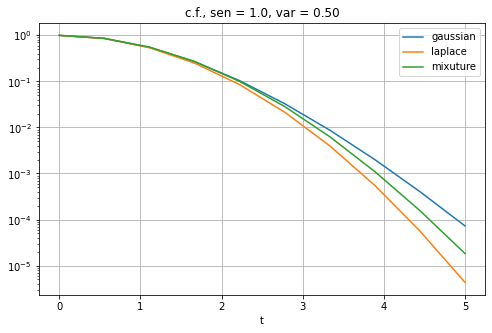

In [6]:
# plot c.f. curve

plt.figure(figsize=(8,5))
for pdf_type in pdf_list:
  plt.semilogy(t_grid,cf_list[pdf_type],label=pdf_names[pdf_type])
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title('c.f., sen = %.1f, var = %.2f' %(sen, variance))

Text(0.5, 1.0, 'epsilon-delta, sen = 1.0, var = 0.50')

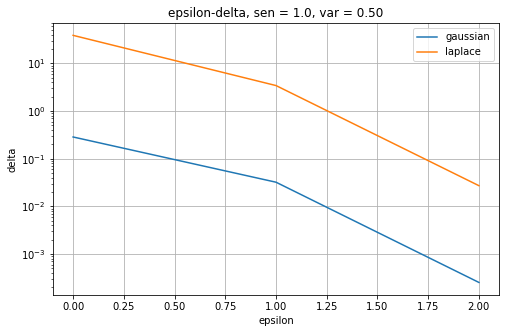

In [15]:
# plot epsilon-delta 

plt.figure(figsize=(8,5))
for pdf_type in pdf_list:
  plt.semilogy(eps_grid,delta_list[pdf_type],label=pdf_names[pdf_type])
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('epsilon')
plt.ylabel('delta')
plt.title('epsilon-delta, sen = %.1f, var = %.2f' %(sen, variance))

In [12]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

tt,ee = np.meshgrid(np.arange(-8,8,0.1),np.arange(0,2,0.1))

a=0.9
z_filter = np.sqrt(N* var_l)*np.exp(-(a+1j*tt)*(ee-N*mean_l)/np.sqrt(N*var_l))/(a+1j*tt)/(np.sqrt(N*var_l)+a+1j*tt)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(tt,ee,np.real(z_filter), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('eps')
ax.set_zlabel('filter');

NameError: name 'var_l' is not defined